## Домашнее задание №2: Глубинные нейронные сети. Pytorch

### Пожалуйста, заполните имя

In [0]:
STUDENT_NAME = "Ruslan Sungatullin"

In [0]:
# Включает режим проверки
try:
    import train_utils
    TEST_MODE = True
except:
    TEST_MODE = False

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, NLLLoss
import torch.nn as nn
from IPython.display import clear_output
from torch import Tensor
import time
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать обучить нейронную сеть с помощью фреймворка Pytorch, изучить подходы к инициализации нейронных сетей и реализовать слои, улучшающие сходимость глубинных нейронных сетей.

### Часть 3. Улучшение сходимости глубинных нейронных сетей
**Dropout**

In [0]:
# Реализуйте функцию train для нашего задания (по аналогии с частью 1)
# Функция должна строить графики loss и accuracy для train и test
# Не забудьте сделать ravel!

def mnist_train_verbose(network, train_dataloader, test_dataloader, epochs):
  t0 = time.time()
  optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
  loss = NLLLoss()
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  for e in range(epochs):
    losses = []
    accuracy = []
    for X, y in train_dataloader:
      X, y = Variable(X.view(X.size(0), -1)), Variable(y, requires_grad=False)
      prediction = network(X)
      mse = loss(prediction, y)
      losses.append(mse.item())
      optimizer.zero_grad()
      mse.backward()
      accuracy.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
      optimizer.step()
    train_loss.append(np.mean(losses))
    train_accuracy.append(np.mean(accuracy))
    losses = []
    accuracy = []
    for X, y in test_dataloader:
      X, y = Variable(X.view(X.size(0), -1)), Variable(y, requires_grad=False)
      prediction = network(X)
      mse = loss(prediction, y)
      accuracy.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
      losses.append(mse.item())
    test_loss.append(np.mean(losses))
    test_accuracy.append(np.mean(accuracy))
    clear_output(True)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(test_loss, label="Test")
    axs[0].plot(train_loss, label="Train")
    axs[1].plot(test_accuracy, label="Test")
    axs[1].plot(train_accuracy, label="Train")
    axs[0].legend()
    axs[1].legend()
    plt.show()
  print(network)
  print("TRAIN LOSS: {0}".format(train_loss[-1]))
  print("TEST LOSS: {0}".format(test_loss[-1]))
  print("TRAIN ACCURACY: {0}".format(train_accuracy[-1]))
  print("TEST ACCURACY: {0}".format(test_accuracy[-1]))
  print("TOTAl TIME: {0}".format(time.time()-t0))
  return train_loss, test_loss, train_accuracy, test_accuracy


Опять загрузим MNIST

In [0]:
from torchvision.datasets import MNIST

to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader_mnist = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [0]:
# Тестовые батчи. Нарисуем их, а потом будем пропускать их через нейронную сеть
images_train, labels_train = next(iter(train_loader_mnist))

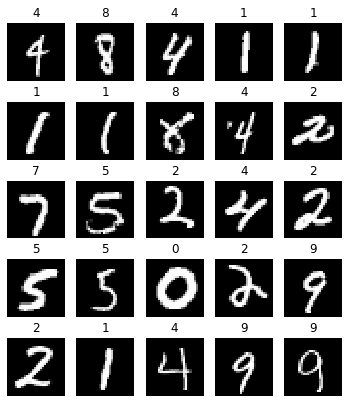

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train.numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(labels_train.numpy()[i])
    plt.axis('off')

Обучим обычную нейронную сеть:

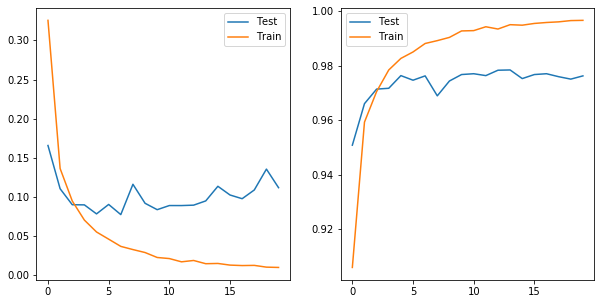

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): LogSoftmax()
)
TRAIN LOSS: 0.009641486124760696
TEST LOSS: 0.11164185371575214
TRAIN ACCURACY: 0.9966351279317697
TEST ACCURACY: 0.9762658227848101
TOTAl TIME: 285.23880076408386


In [84]:
network1 = nn.Sequential(nn.Linear(784, 100),
                         nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.ReLU(),
                         nn.Linear(100, 10),
                         nn.LogSoftmax())

mnist_train_verbose(network1, train_loader_mnist, test_loader_mnist, 20);

Можно было остановиться на 6-7 эпохах, дальше началось переобучение.

In [0]:
# Проверка
if TEST_MODE:
    from importlib import reload
    reload(train_utils)
    train_utils.train(network1, train_loader_mnist, test_loader_mnist, 10, learning_rate=0.001, ravel_init=True,
                      need_accuracies=True)

Реализуйте DropConnect. 

In [0]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# Не забудьте заменить все вероятности на p при test-проходе!

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        weight_bias = torch.cat((self.weight, self.bias))
        ones = Variable(-torch.ones(x.data.shape[0] , 1), requires_grad=False)
        expanded_x = torch.cat((x, ones), 1)
        mask = torch.Tensor(weight_bias.size())
        if(self.training):
            mask.bernoulli_(self.p)
        else:
            mask.fill_(self.p)
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(expanded_x, torch.mul(weight_bias, mask))
        return output

Сравните графики обучения нейроных сетей:
<i> 
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [0]:
network_dropout = nn.Sequential(nn.Linear(784, 200), 
                                nn.Dropout(), 
                                nn.ReLU(),
                                nn.Linear(200, 200),
                                nn.Dropout(),
                                nn.ReLU(),
                                nn.Linear(200 ,10),
                                nn.LogSoftmax())

In [0]:
network_dropconnect = nn.Sequential(DropConnect(784, 200),
                                    nn.ReLU(),
                                    DropConnect(200, 200),
                                    nn.ReLU(),
                                    DropConnect(200, 10),
                                    nn.LogSoftmax())

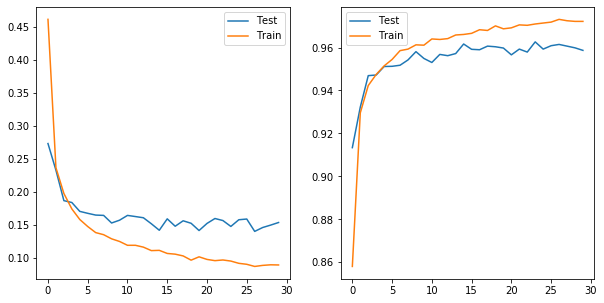

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)
TRAIN LOSS: 0.08975657273624052
TEST LOSS: 0.15399827612151357
TRAIN ACCURACY: 0.9721648454157783
TEST ACCURACY: 0.9586629746835443
TOTAl TIME: 460.03002524375916


In [89]:
# Используйте mnist_train_verbose
mnist_train_verbose(network_dropout, train_loader_mnist, test_loader_mnist, 30);

С использованием Dropout точность только немного понищиась. Возможно стоило провести больше эпох обучения.

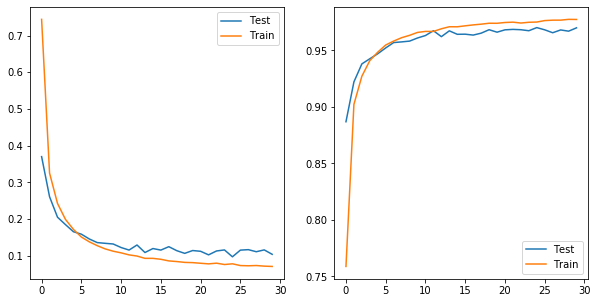

Sequential(
  (0): DropConnect()
  (1): ReLU()
  (2): DropConnect()
  (3): ReLU()
  (4): DropConnect()
  (5): LogSoftmax()
)
TRAIN LOSS: 0.07094960366345958
TEST LOSS: 0.10398781261866606
TRAIN ACCURACY: 0.9774342572850035
TEST ACCURACY: 0.9700356012658228
TOTAl TIME: 474.38754773139954


In [90]:
mnist_train_verbose(network_dropconnect, train_loader_mnist, test_loader_mnist, 30);

Точно оказалась выще, чем с использованием Dropout, но все еще ниже, чем без исаользования регуляризаторов.

По графикам видно, что и Dropout, и DropConnect помогают бороться с переобучением.

**Нормализация**

Давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

In [0]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, num_features, alpha=0.01, mean=0, std=0.01):
        super(LayerNormalization, self).__init__()
        self.alpha = alpha
        self.mean = Variable(torch.zeros(1), requires_grad=False)
        self.std = Variable(torch.ones(1), requires_grad=False)
        self.gamma = nn.Parameter(torch.Tensor(1, num_features).normal_(mean=mean, std=std))
        self.beta = nn.Parameter(torch.Tensor(1, num_features).normal_(mean=mean, std=std))
    
    def forward(self, x):
        eps = 1e-8
        self.mean = (1. - self.alpha) * self.mean + self.alpha * x.mean()
        self.std = (1. - self.alpha) * self.std + self.alpha * x.std()
        if(self.training):
            x_mean = x.mean(dim=1, keepdim=True)
            x_std = x.std(dim=1, keepdim=True)
            x_norm = (x - x_mean) / (x_std + eps)
        else:
            x_norm = (x - self.mean.expand(x.size())) / (self.std.expand(x.size()) + eps)
        return self.gamma.expand(x.size()) * x_norm  - self.beta.expand(x.size())

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [0]:
# Не забудьте убрать bias при батч-нормализации
# Используйте mnist_train_verbose
network_bn = nn.Sequential(nn.Linear(784, 200, bias=False),
                           nn.BatchNorm1d(200),
                           nn.ReLU(),
                           nn.Linear(200, 200, bias=False),
                           nn.BatchNorm1d(200),
                           nn.ReLU(),
                           nn.Linear(200, 10),
                           nn.LogSoftmax())

In [0]:
network_ln = nn.Sequential(nn.Linear(784, 200, bias=False),
                           LayerNormalization(200),
                           nn.ReLU(),
                           nn.Linear(200, 200, bias=False),
                           LayerNormalization(200),
                           nn.ReLU(),
                           nn.Linear(200, 10),
                           nn.LogSoftmax())

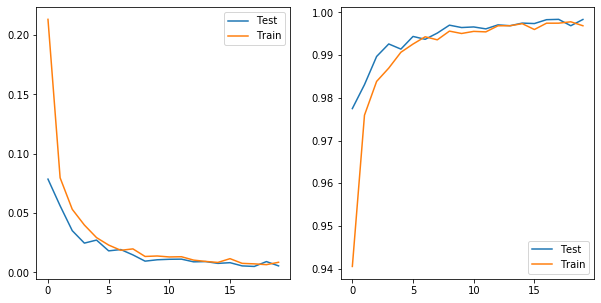

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=False)
  (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=False)
  (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)
TRAIN LOSS: 0.008454140873462298
TEST LOSS: 0.005418658544931725
TRAIN ACCURACY: 0.9968627842928216
TEST ACCURACY: 0.9983342217484008
TOTAl TIME: 535.4855616092682


In [94]:
mnist_train_verbose(network_bn, train_loader_mnist, train_loader_mnist, 20);

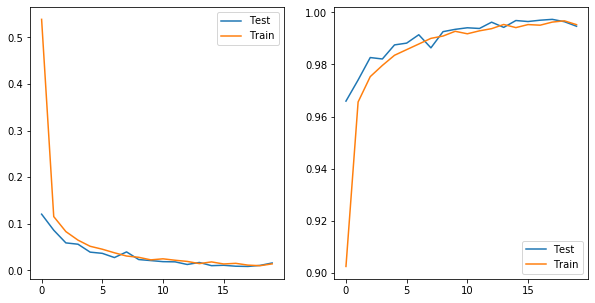

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=False)
  (1): LayerNormalization()
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=False)
  (4): LayerNormalization()
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)
TRAIN LOSS: 0.013894223606276975
TEST LOSS: 0.015841975440343183
TRAIN ACCURACY: 0.9952636371712864
TEST ACCURACY: 0.9946528518123667
TOTAl TIME: 530.559339761734


In [9]:
mnist_train_verbose(network_ln, train_loader_mnist, train_loader_mnist, 20);

За то же число эпох использование нормализации дало результат лучше. Переобучение не заметно на обоих подходах. Быстрее сходится. LayerNormalization оказался чуть хуже, чем BatchNormalization.

Спасибо за выполнение заданий!  

**Обратите внимание:**  
Ранее было отправлено домашнее задание (введение в pytorch, инициализация нейронных сетей) - оно тоже является обязательным!